In [1]:
import zipfile, struct, warnings, requests, struct
from io import StringIO, BytesIO

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import astropy
from astropy.io.votable import parse_single_table
from astroquery.utils.tap.core import TapPlus
import pvl

# from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go
# import plotly
# init_notebook_mode()

from IPython.display import Image, display

%matplotlib inline
warnings.simplefilter('ignore')

# MIDAS data analysis with the PSA and EPN-TAP

## EPN-TAP

EPN-TAP is the Europlanet extension of the Table Access Protocol (TAP) commonly used to query data in astronomical archives. The PSA supports EPN-TAP, although with a limited number of fields populated - this will improve, at least for geometry, in the coming months. 

First we have to make a connection to the server:

In [2]:
tap_url = 'https://archives.esac.esa.int/psa/epn-tap/tap/'
psa = TapPlus(url=tap_url)

Created TAP+ (v1.0.1) - Connection:
	Host: archives.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


EPN-TAP uses a SQL-like language to query the database. A simple first query is to count the number of rows (=number of products):

In [3]:
query = 'SELECT COUNT(1) from epn_core'
result = psa.launch_job(query).get_data()
print('Number of products in the PSA: {:d}'.format(result['count'][0]))

Number of products in the PSA: 8848192


Equally there is an column giving the estimatez size of each product, which we can sum to get the size of the archive. This is only the size of the latest product for those (PDS4) products that have multiple versions:

In [4]:
query = 'SELECT SUM(access_estsize) from epn_core' 
result = psa.launch_job(query).get_data() # in kbyte
print('Total size of PSA (GB): {:f}'.format(result['sum'][0]/1024./1024./1024.))

Total size of PSA (GB): 51.038188


You can also query selected columns, and order them - for example here we list the top 10 largest products:

In [5]:
query = 'SELECT TOP 10 granule_uid, access_estsize from epn_core WHERE access_estsize IS NOT NULL ORDER BY access_estsize DESC'
result = psa.launch_job(query).get_data()
result

granule_uid,access_estsize
object,int32
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_mir_20160414t023000-20160414t025700-c-0-6,165414637
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_mir_20160414t033000-20160414t035700-c-0-7,165233465
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_tir_20161126t015500-20161126t024700-10-9,125029063
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_tir_20161126t031300-20161126t040500-10-10,124966100
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_tir_20170305t233321-20170306t065000-50-3,102403605
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_tir_20170301t230000-20170302t020000-46-2,95586863
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_tir_20160614t005100-20160614t014200-0-1,84912674
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_tir_20161122t145745-20161122t192620-9-3,67186534
urn:esa:psa:em16_tgo_acs:data_raw:acs_raw_sc_tir_20170305t192400-20170305t233311-50-2,62398895


# MIDAS data
- MIDAS was an Atomic Force Microscope on Rosetta
- Query and extract data into pandas as before

In [6]:
query = "SELECT * FROM epn_core WHERE target_name='67P' AND instrument_name='MIDAS'"
data = psa.launch_job(query).get_data().to_pandas()

str_df = data.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    data[col] = str_df[col]
    
print('Number of returned products: {:d}'.format(len(data)))
data.head()

Number of returned products: 2000


,access_estsize,access_format,access_url,c1max,c1min,c1_resol_max,c1_resol_min,c2max,c2min,c2_resol_max,...,s_region,target_class,target_name,thumbnail_url,time_exp_max,time_exp_min,time_max,time_min,time_sampling_step_max,time_sampling_step_min
0,686,application/x-pds-zip,https://archives.esac.esa.int/psa/pdap/downloa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,comet,67P,,NaN,NaN,2.457038e+06,2.457038e+06,NaN,NaN
1,686,application/x-pds-zip,https://archives.esac.esa.int/psa/pdap/downloa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,comet,67P,,NaN,NaN,2.457038e+06,2.457038e+06,NaN,NaN
2,25225,application/x-pds-zip,https://archives.esac.esa.int/psa/pdap/downloa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,comet,67P,,NaN,NaN,2.457092e+06,2.456983e+06,NaN,NaN
3,25225,application/x-pds-zip,https://archives.esac.esa.int/psa/pdap/downloa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,comet,67P,,NaN,NaN,2.457092e+06,2.456983e+06,NaN,NaN
4,25225,application/x-pds-zip,https://archives.esac.esa.int/psa/pdap/downloa...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,,comet,67P,,NaN,NaN,2.457092e+06,2.456983e+06,NaN,NaN


The 2k limit on products here is the limit in AstroQuery for synchronous queries - to get more products we could switch to an asynchronous query...

Each MIDAS product is described by a three-letter acronym at the start. You can read more about the archiving conventions here: http://pdssbn.astro.umd.edu/holdings/ro-c-midas-3-esc2-samples-v1.0/document/mid_eaicd.pdf. If you want to get really technical you can also look at the User Manual [http://pdssbn.astro.umd.edu/holdings/ro-c-midas-3-esc2-samples-v1.0/document/mid_user.pdf].

MIDAS images all start with IMG and the two letters at the end of the product name describe the image channels used - the most useful is ZS, which is the topographic channel. So we'll add some new colums to allow us to select the data type and channel, and filter to just those:

Here we will first try to grab an image used in this paper (Figure 3):

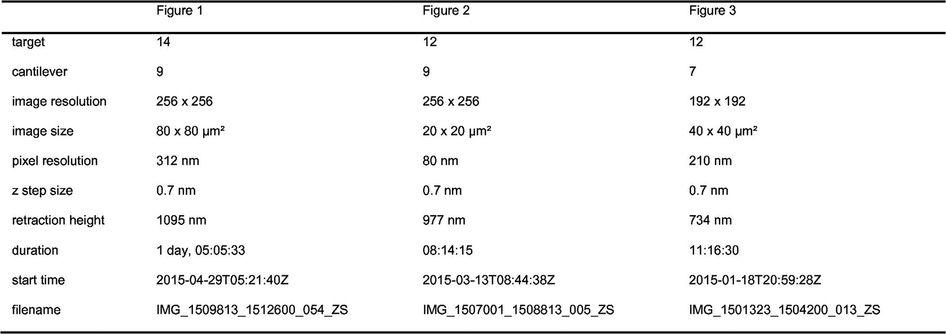

In [7]:
Image(url='https://media.nature.com/full/nature-assets/nature/journal/v537/n7618/images/nature19091-st1.jpg', embed=True)

The EPN-TAP date column returns a Julian date, so we will have to convert the values in the table to that format

In [8]:
fig1_start = pd.Timestamp('2015-01-18 20:59:28Z') 
fig1_duration = pd.Timedelta(hours=11, minutes=16, seconds=30)
fig1_end = fig1_start + fig1_duration

In [9]:
fig1_start, fig1_end

(Timestamp('2015-01-18 20:59:28+0000', tz='UTC'),
 Timestamp('2015-01-19 08:15:58+0000', tz='UTC'))

We will add a small delta to each end of the window to avoid any rounding issues

In [10]:
fig1_start -= pd.Timedelta(minutes=1)
fig1_end += pd.Timedelta(minutes=1)

In [11]:
fig1_start.to_julian_date(), fig1_end.to_julian_date()

(2457041.3739351854, 2457041.845115741)

In [12]:
query = "SELECT * FROM epn_core WHERE target_name='67P' AND instrument_name='MIDAS' AND time_min>'%s' AND time_max<'%s'" % (fig1_start.to_julian_date(), fig1_end.to_julian_date())
data = psa.launch_job(query).get_data().to_pandas()

str_df = data.select_dtypes([np.object])
str_df = str_df.stack().str.decode('utf-8').unstack()
for col in str_df:
    data[col] = str_df[col]
    
len(data)

6

If we want to convert back to UTC time to check, we can do it like this:

In [13]:
pd.to_datetime(data.time_min.iloc[0], origin='julian', unit='D')

Timestamp('2015-01-18 20:59:28.073990400')

## MIDAS specific filtering of products


In [14]:
data['product_id'] = data.granule_uid.apply( lambda uid: uid.split(':')[-1])
data['data_type'] = pd.Series(data.product_id.apply( lambda prod: prod[0:3] ), name='data_type')
data.data_type.unique()

array(['IMG', 'LIN'], dtype=object)

We are interested in the IMG files here:

In [15]:
images = data[ data.data_type=='IMG' ].copy()
images['channel'] = images.product_id.apply( lambda prod: prod[-2:] )
images = images[ images.channel=='ZS' ]
len(images)

2

Let's check the product IDs (last part of ther UID) - in fact let's make a column containing that:

In [16]:
images['product_id'] = images.granule_uid.apply(lambda x: x.split(':')[-1])

Now let's see the data set and product IDs for these two hits:

In [17]:
images[['granule_gid', 'product_id']]

,granule_gid,product_id
1,RO-C-MIDAS-3-ESC1-SAMPLES-V3.0:DATA,IMG_1501323_1504200_013_ZS
5,RO-C-MIDAS-5-PRL-TO-EXT3-V1.0:DATA,IMG_1501323_1504200_013_ZS


Ahh, so it's the same product, but in twoi different datasets - one raw data and one derived. We'll look at the original one (used in the paper above)

In [18]:
image = images.loc[1]
image

access_estsize                                                            27127
access_format                                             application/x-pds-zip
access_url                    https://archives.esac.esa.int/psa/pdap/downloa...
c1max                                                                       NaN
c1min                                                                       NaN
c1_resol_max                                                                NaN
c1_resol_min                                                                NaN
c2max                                                                       NaN
c2min                                                                       NaN
c2_resol_max                                                                NaN
c2_resol_min                                                                NaN
c3max                                                                       NaN
c3min                                   

Hmm, there are lots of "NaN" values because many fields in the PSA's EPN-TAP database have not been populated. But there is a thumbnail_url - let's look at that:

In [19]:
image.thumbnail_url

'https://archives.esac.esa.int/psa/pdap/fileaccess?ID=INTERNATIONALsROSETTAsMISSION/RO-C-MIDAS-3-ESC1-SAMPLES-V3.0/BROWSE/PRV_1501323_1504200_013_ZS.JPG'

So it's a simple JPG that we can probably view:

In [20]:
Image(url=image.thumbnail_url)

As well as a thumbnail URL, the database entry points to how we can download the actual data:

In [21]:
image.access_url

'https://archives.esac.esa.int/psa/pdap/download?CLIENT=epntap&RESOURCE_CLASS=PRODUCT&ID=RO-C-MIDAS-3-ESC1-SAMPLES-V3.0:DATA:IMG_1501323_1504200_013_ZS'

In [22]:
r = requests.get(url=image.access_url)
zip = zipfile.ZipFile(BytesIO(r.content))
zip.namelist()

['RO-C-MIDAS-3-ESC1-SAMPLES-V3.0/BROWSE/PRV_1501323_1504200_013_ZS.JPG',
 'RO-C-MIDAS-3-ESC1-SAMPLES-V3.0/DATA/IMG/IMG_1501323_1504200_013_ZS.IMG',
 'RO-C-MIDAS-3-ESC1-SAMPLES-V3.0/DATA/IMG/IMG_1501323_1504200_013_ZS.LBL',
 'RO-C-MIDAS-3-ESC1-SAMPLES-V3.0/DOCUMENT/MID_TIP_IMAGES.PDF',
 'RO-C-MIDAS-3-ESC1-SAMPLES-V3.0/BROWSE/PRV_1501323_1504200_013_ZS.LBL',
 'RO-C-MIDAS-3-ESC1-SAMPLES-V3.0/DOCUMENT/MID_EAICD.PDF',
 'RO-C-MIDAS-3-ESC1-SAMPLES-V3.0/DOCUMENT/MID_CALIBRATION.PDF',
 'inventory.txt']

This zip contains quite a lot of information, since it automatically includes documents of relevance. For now we just want the image file and label in the data directory:

In [23]:
label_file = [filename for filename in zip.namelist() if (filename.endswith('.LBL') and filename.split('/')[1]=='DATA')][0]
data_file = [filename for filename in zip.namelist() if (filename.endswith('.IMG') and filename.split('/')[1]=='DATA')][0]

In [24]:
label_file, data_file

('RO-C-MIDAS-3-ESC1-SAMPLES-V3.0/DATA/IMG/IMG_1501323_1504200_013_ZS.LBL',
 'RO-C-MIDAS-3-ESC1-SAMPLES-V3.0/DATA/IMG/IMG_1501323_1504200_013_ZS.IMG')

The label file is a PDS3 label in a format called PVL - there is a library for this so we can load and parse the label:

In [25]:
label = pvl.load(zip.open(label_file))

The raw data file we will just read into memory to process later:

In [26]:
rawdata = zip.open(data_file).read()

Now we need to know a bit more - if you browse the label more carefully you can see that the .IMG file contains two parts - an ASCII header with a fixed length of 2048 bytes, and some binary data. 

In [27]:
offset = label['BCR_HEADER']['BYTES']
zcal = float(label['BCR_IMAGE']['SCALING_FACTOR'])
xpix = int(label['BCR_IMAGE']['LINE_SAMPLES'])
ypix = int(label['BCR_IMAGE']['LINES'])
xpix_m = float(label['HORIZONTAL_PIXEL_SCALE'])
ypix_m = float(label['VERTICAL_PIXEL_SCALE'])
xlen_nm = xpix_m * xpix * 1.e9
ylen_nm = ypix_m * xpix * 1.e9
length = xpix * ypix

Data are stored as little-endian signed integers - simply read them using the struct module, re-shape according to the label data, rescale so that zero is the minimum and multiply by the Z (height) calibration factor.

In [28]:
data = np.array(struct.unpack('<%dh'%length, rawdata[offset:]), dtype=np.float)
data = data.reshape(xpix,ypix)
data -= data.min()
data *= zcal

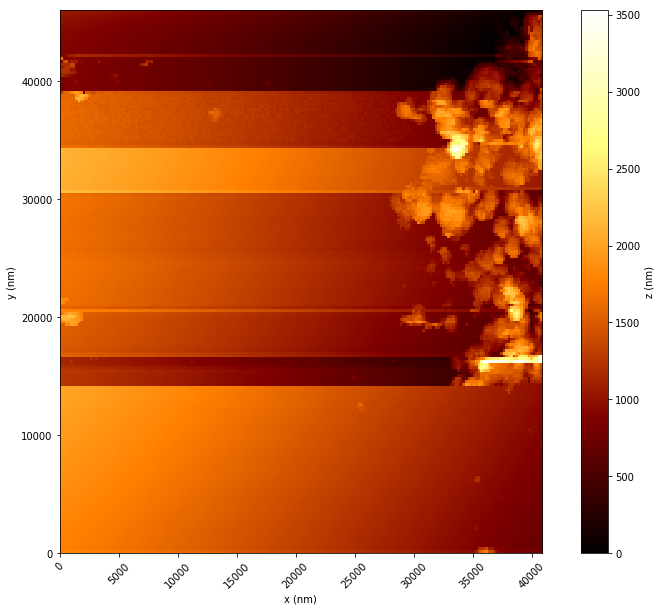

In [29]:
# Now plot it! First with Matplotlib:
fig, ax = plt.subplots(figsize=(14,10))
extent = [0., xlen_nm, 0., ylen_nm]
im = ax.imshow(data, interpolation='nearest', extent=extent, cmap=plt.cm.afmhot)
cbar = plt.colorbar(im)
plt.setp(ax.get_xticklabels(), rotation=45)
ax.set_xlabel('x (nm)')
ax.set_ylabel('y (nm)')
cbar.set_label('z (nm)')

Great, this looks like the preview image above! We can also display in 3D and interactive using plotly:

In [30]:
xvals = np.linspace(0., xlen_nm, num=xpix)
yvals = np.linspace(0., ylen_nm, num=ypix)
xs, ys = np.meshgrid(xvals, yvals)
img_data = [ go.Surface(x=xs, y=ys, z=data/100.) ]
layout = go.Layout(title=image.product_id, autosize=True, width=800, height=550, margin=dict(l=65, r=50, b=65, t=90), scene = dict(aspectmode='data'))
go.FigureWidget(data=img_data, layout=layout)#, config={'showLink': False, 'displaylogo': False, 'modeBarButtonsToRemove': ['sendDataToCloud']})

FigureWidget({
    'data': [{'type': 'surface',
              'uid': '1172c96c-6382-45e0-bcdd-2461946b4c3b',
 …

In [31]:

data = [go.Bar(
            x=['giraffes', 'orangutans', 'monkeys'],
            y=[20, 14, 23]
    )]
layout = {'yaxis': {'range': [0, 25]}}
fig = go.FigureWidget(data, layout)
fig

FigureWidget({
    'data': [{'type': 'bar',
              'uid': 'f0955939-3a96-4dec-97ef-70430b7a0e48',
     …

## The particle catalogue

In [32]:
prod_id = 'MID_PARTICLE_TABLE'

In [33]:
query = "SELECT * FROM epn_core WHERE instrument_name='MIDAS' AND GRANULE_UID LIKE '%MID_PARTICLE_TABLE'"
data = psa.launch_job(query).get_data()

In [34]:
catalogue_url = data['access_url'].data[0]

In [35]:
r = requests.get(url=catalogue_url)
zip = zipfile.ZipFile(BytesIO(r.content))
zip.namelist()

['RO-C-MIDAS-5-PRL-TO-EXT3-V1.0/DATA/MID_PARTICLE_TABLE.TAB',
 'RO-C-MIDAS-5-PRL-TO-EXT3-V1.0/DATA/MID_PARTICLE_TABLE.LBL',
 'inventory.txt']

In [36]:
label_file = [filename for filename in zip.namelist() if (filename.endswith('.LBL') and filename.split('/')[1]=='DATA')][0]
data_file = [filename for filename in zip.namelist() if (filename.endswith('.TAB') and filename.split('/')[1]=='DATA')][0]

In [37]:
label_file, data_file

('RO-C-MIDAS-5-PRL-TO-EXT3-V1.0/DATA/MID_PARTICLE_TABLE.LBL',
 'RO-C-MIDAS-5-PRL-TO-EXT3-V1.0/DATA/MID_PARTICLE_TABLE.TAB')

In [38]:
label = pvl.load(zip.open(label_file))   
table_meta = label['PARTICLE_TABLE']

# extract the column names from the label file
cols = []
for item in table_meta:
    if item[0] != 'COLUMN':
        continue
    cols.append(item[1]['NAME'])

# read the CSV file
catalogue = pd.read_table(zip.open(data_file), sep=',', delim_whitespace=False, names=cols, skiprows=1)

# tidy it up a bits
for col in catalogue.columns:
    if catalogue[col].dtype == 'O':
        catalogue[col] = catalogue[col].str.strip()

In [39]:
catalogue.head()

,PARTICLE_ID,PARTICLE_SCAN_FILE,PARTICLE_MASK_FILE,PRE_SCAN_FILE,PRE_SCAN_FLAG,PARTICLE_FLAG,SCAN_QUALITY_FLAG,MULTIPLE_FRAGMENTS_FLAG,TRUST_HEIGHT_FLAG,PHYSICAL_ALTERATION_FLAG,...,X_SCAN_SIZE,Y_SCAN_SIZE,TIP_NUMBER,TARGET_NUMBER,LAST_TIP_IMAGE_START,ARCHIVE_FILE_LAST_TIP_IMAGE,BOUNDING_BOX_ROW_MIN,BOUNDING_BOX_ROW_MAX,BOUNDING_BOX_COL_MIN,BOUNDING_BOX_COL_MAX
0,2014-11-14T120150_P01_T10,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,2,1,2,0,1,0,...,80.3,80.3,5,10,,,0,6,27,32
1,2014-11-14T120150_P02_T10,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,2,1,3,0,2,0,...,80.3,80.3,5,10,,,14,18,0,6
2,2014-11-14T120150_P03_T10,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,2,1,3,0,2,0,...,80.3,80.3,5,10,,,10,30,26,186
3,2014-11-14T120150_P04_T10,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,2,1,3,0,2,0,...,80.3,80.3,5,10,,,31,36,153,164
4,2014-11-14T120150_P05_T10,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,RO-D-MIDAS-3-PRL-SAMPLES-V3.0/IMG_1429710_1432...,2,1,3,0,2,0,...,80.3,80.3,5,10,,,31,36,0,26


In [40]:
catalogue.columns

Index(['PARTICLE_ID', 'PARTICLE_SCAN_FILE', 'PARTICLE_MASK_FILE',
       'PRE_SCAN_FILE', 'PRE_SCAN_FLAG', 'PARTICLE_FLAG', 'SCAN_QUALITY_FLAG',
       'MULTIPLE_FRAGMENTS_FLAG', 'TRUST_HEIGHT_FLAG',
       'PHYSICAL_ALTERATION_FLAG', 'LINKED_PARTICLE_ID',
       'LINKED_PARTICLE_SCAN', 'LINKED_PARTICLE_FLAG', 'MASTER_PARTICLE_ID',
       'MASTER_PARTICLE_SCAN', 'AREA_PIXEL', 'AREA_UM', 'Z_MIN_VALUE',
       'Z_MAX_VALUE', 'Z_MEAN_VALUE', 'PARTICLE_HEIGHT', 'PARTICLE_STD_DEV',
       'X_STEP_SIZE', 'Y_STEP_SIZE', 'X_SCAN_ORIGIN', 'Y_SCAN_ORIGIN',
       'X_SCAN_SIZE', 'Y_SCAN_SIZE', 'TIP_NUMBER', 'TARGET_NUMBER',
       'LAST_TIP_IMAGE_START', 'ARCHIVE_FILE_LAST_TIP_IMAGE',
       'BOUNDING_BOX_ROW_MIN', 'BOUNDING_BOX_ROW_MAX', 'BOUNDING_BOX_COL_MIN',
       'BOUNDING_BOX_COL_MAX'],
      dtype='object')

OK, let's find the largest (area) particles in the catalogue:

In [41]:
catalogue.sort_values(by='AREA_UM', ascending=False)[['PARTICLE_SCAN_FILE', 'AREA_UM']].head(5)

,PARTICLE_SCAN_FILE,AREA_UM
660,RO-C-MIDAS-3-EXT2-SAMPLES-V3.0/IMG_1612423_161...,4473.801
664,RO-C-MIDAS-3-EXT2-SAMPLES-V3.0/IMG_1612423_161...,2151.731
1037,RO-C-MIDAS-3-EXT2-SAMPLES-V3.0/IMG_1615223_161...,2116.979
656,RO-C-MIDAS-3-EXT2-SAMPLES-V3.0/IMG_1612423_161...,1853.348
601,RO-C-MIDAS-3-EXT2-SAMPLES-V3.0/IMG_1609623_161...,1721.125


Let's see if we can retrieve the scan of the largest particle    

In [42]:
largest = catalogue.sort_values(by='AREA_UM', ascending=False)['PARTICLE_SCAN_FILE'].iloc[0]
largest

'RO-C-MIDAS-3-EXT2-SAMPLES-V3.0/IMG_1612423_1615300_019_ZS'

We need to convert the dataset and product ID from the catalogue into the granule UID  used in EPN-TAP:

In [43]:
largest_uid = largest.split('/')[0] + ':DATA:' + largest.split('/')[1]
largest_uid

'RO-C-MIDAS-3-EXT2-SAMPLES-V3.0:DATA:IMG_1612423_1615300_019_ZS'

In [44]:
query = "SELECT * FROM epn_core WHERE granule_uid='%s'" % largest_uid
data = psa.launch_job(query).get_data()

Now let's look at the browse product for this:

In [45]:
thumbnail_url = data['thumbnail_url'].data[0].decode('utf-8')

In [46]:
Image(url=thumbnail_url)